In [1]:
#Load in the tidyverse and randomForest library for data wrangling and final prediction
library(tidyverse)
library(randomForest)

#Read in all data files given
gender <- read_csv("/kaggle/input/titanic/gender_submission.csv")
test <- read_csv("/kaggle/input/titanic/test.csv")
train <- read_csv("/kaggle/input/titanic/train.csv")

#Select the variables that I believe to be the most significant in the train and test file
train_selected <- train %>%
    select(PassengerId, Name, Survived, Pclass, Sex, Age, Fare, SibSp, Embarked) 
test_selected <- test %>%
    select(PassengerId, Name, Pclass, Sex, Age, Fare, SibSp, Embarked)

#Check how many rows are in each dataset
nrow(train_selected)
nrow(test_selected)

#Check the number of NAs in each dataset as well as how many of the missing values are in Age and how many are in Embarked
sum(is.na(train_selected))
sum(is.na(train_selected$Age))
sum(is.na(train_selected$Embarked))
sum(is.na(test_selected))
sum(is.na(test_selected$Age))
sum(is.na(test_selected$Embarked))

#Find the median age in each data frame to substitute in for the missing values
median(train_selected$Age, na.rm = TRUE)
median(test_selected$Age, na.rm = TRUE)
train_selected$Age  <- ifelse(is.na(train_selected$Age), 28, train_selected$Age)
test_selected$Age  <- ifelse(is.na(test_selected$Age), 27, test_selected$Age)

#Find the Mode in the train data frame to substitute in for the missing values
train_selected %>%
    group_by(Embarked) %>%
    summarize(total = length(Embarked))
train_selected$Embarked  <- ifelse(is.na(train_selected$Embarked), "S", train_selected$Embarked)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Rows: 418 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): PassengerId, Survived

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Spec

[1] 891

[1] 418

[1] 179

[1] 177

[1] 2

[1] 87

[1] 86

[1] 0

[1] 28

[1] 27

Embarked,total
<chr>,<int>
C,168
Q,77
S,644
NA,2


In [2]:
#Find the proportion of females and males that survived (females more likely to survive)
train_selected %>%
    group_by(Sex) %>%
    summarize(prop_survived = sum(Survived, na.rm = TRUE)/ length(Survived))

#Find the proportion that survived for each class (higher class mre likely to survive)
train_selected %>%
    group_by(Pclass) %>%
    summarize(prop_survived = sum(Survived, na.rm = TRUE)/ length(Survived))

#Find the proportion that survived for number of spouses or siblings on board (5 or more did not survive)
train_selected %>%
    group_by(SibSp) %>%
    summarize(prop_survived = sum(Survived, na.rm = TRUE)/ length(Survived))

Sex,prop_survived
<chr>,<dbl>
female,0.7420382
male,0.1889081


Pclass,prop_survived
<dbl>,<dbl>
1,0.6296296
2,0.4728261
3,0.2423625


SibSp,prop_survived
<dbl>,<dbl>
0,0.3453947
1,0.5358852
2,0.4642857
3,0.2500000
4,0.1666667
5,0.0000000
8,0.0000000


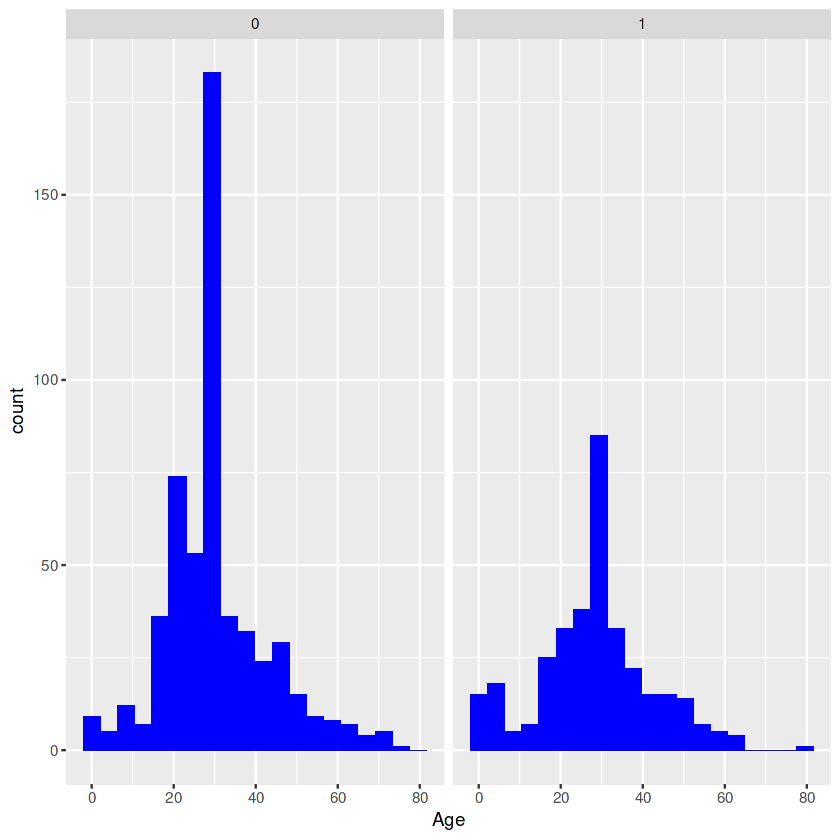

`summarise()` has grouped output by 'Pclass', 'Sex'. You can override using the
`.groups` argument.


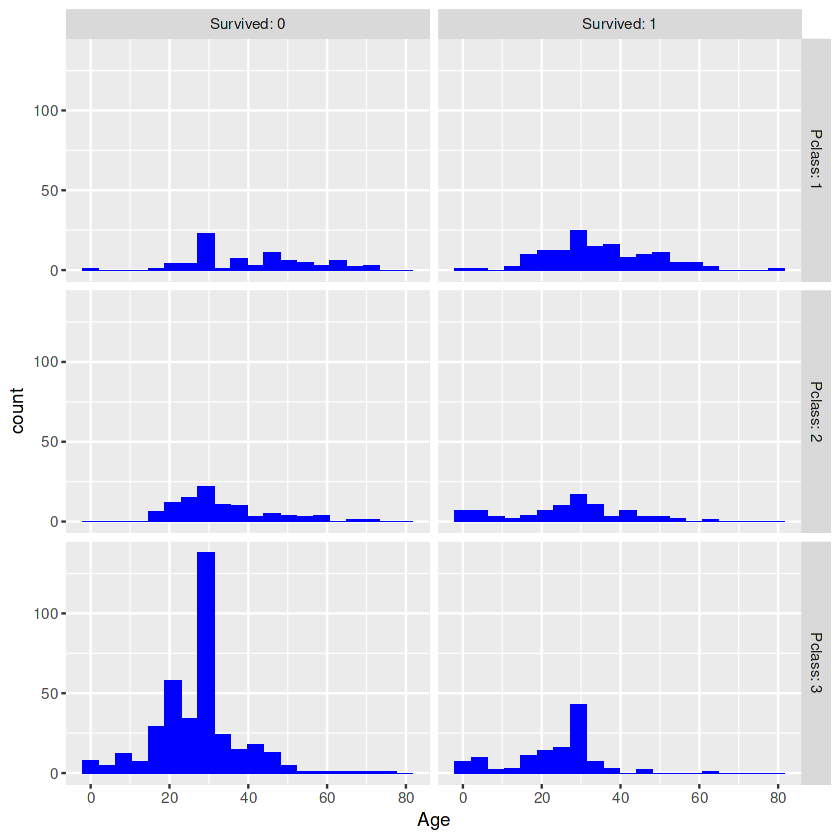

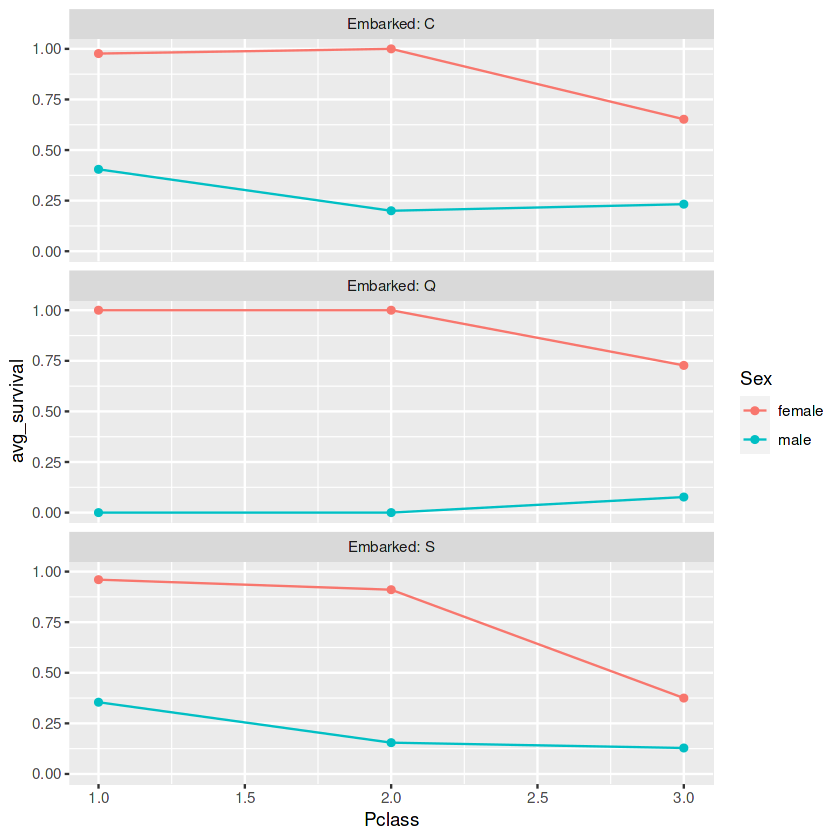

In [3]:
#Visualize the age distribution for those that did and did not survive (majority of middle aged people were on board)
ggplot(train_selected, aes(Age)) +
    geom_histogram(bins = 20, fill = "blue") + 
    facet_wrap(~ Survived)

#Visualize the age distribution while faceting both class and survival variables (a large amount of middle aged third class people did not survive)
ggplot(train_selected, aes(Age)) +
    geom_histogram(bins = 20, fill = "blue") + 
    facet_grid(Pclass ~ Survived, labeller = label_both)

#Visualize average survival rate vs class, faceted by where they Embarked from and colored by sex
#Males that got on last (Queenstown) had a very low chance of survival, regardless of class
train_selected %>%
    group_by(Pclass, Sex, Embarked) %>%
    summarize(avg_survival = mean(Survived, na.rm = TRUE)) %>%
    ggplot(aes(Pclass, avg_survival, color = Sex)) +
        geom_point() +
        geom_line() +
        facet_wrap(~ Embarked, nrow = 3, labeller = label_both)


In [4]:
#From my EDA I can assume that the most important variables to include in the randomForest equation would 
#be Pclass, Sex, Age, SibSP, Embarked, the relationship between Pclass and Age, and the relationship between Embarked and Sex

In [5]:
#Set a seed so that the algorithm is not randomized each time
set.seed(40)

#Make Survived a factor
train_selected$Survived <- as.factor(train_selected$Survived) 

#Run a randomForest model and prediction
model <- randomForest(Survived ~ Pclass + Sex + Age + SibSp + Embarked + Pclass:Age + Embarked:Sex, data=train_selected, ntree=20000)
model
prediction <- predict(model, newdata = test_selected)
prediction

#OOB estimate of error rate is 18.07% so I had about 81.93% accuracy


Call:
 randomForest(formula = Survived ~ Pclass + Sex + Age + SibSp +      Embarked + Pclass:Age + Embarked:Sex, data = train_selected,      ntree = 20000) 
               Type of random forest: classification
                     Number of trees: 20000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 18.07%
Confusion matrix:
    0   1 class.error
0 509  40  0.07285974
1 121 221  0.35380117

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  0   0   0   0   0   0   1   0   1   0   0   0   1   0   1   1   0   0   0   0 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
  0   1   1   0   1   0   1   0   0   0   0   0   0   0   0   0   1   1   0   0 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
  0   0   0   1   1   0   0   0   1   0   0   0   1   1   0   0   0   0   0   1 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
  0   0   0   1   1   1   1   0   0   1   1   0   0   0   1   0   0   1   0   1 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
  1   0   0   0   0   0   1   1   1   1   0   0   1   0   0   0   1   0   0   0 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
  1   0   0   0   1   0   0   0   0   0   0   1   1   1   1   0   0   1   0   1 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
  1   0   1   0   0   1   0   1   0   0   0   0   1   0   0   0   0   0   1   0 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
  0   1   0   0   0   0   0   0   0   0   1   0   0   0   0   0   1   1   0   1 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
  1   1   1   0   0   0   0   0   1   1   0   0   0   0   0   1   1   0   1   1 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
  0   0   1   0   1   0   1   0   0   0   0   0   0   0   1   0   1   1   0   1 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 
  1   1   1   1   0   0   0   0   1   0   0   0   0   1   0   0   1   0   1   0 
221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 
  1   0   1   0   1   1   0   1   0   0   0   1   0   0   0   0   0   0   1   1 
241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 
  1   1   0   0   0   0   1   0   1   1   1   0   0   0   0   0   0   0   1   0 
261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 
  0   0   1   1   0   0   0   0   1   0   0   0   1   1   0   1   0   0   0   0 
281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 
  1   1   1   1   1   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0 
301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 
  0   0   0   0   1   1   0   1   0   0   0   0   0   0   1   1   0   0   0   0 
321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 
  0   0   0   0   1   0   1   0   0   0   1   0   0   1   0   0   0   0   0   0 
341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 
  0   0   0   1   0   1   0   0   0   1   1   0   0   0   1   0   1   0   0   0 
361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 
  0   1   1   0   1   0   0   1   1   0   0   1   0   0   1   1   0   0   0   0 
381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 
  0   0   1   0   0   1   0   0   0   0   0   1   0   0   0   1   0   1   0   0 
401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 
  1   0   1   0   1   0   0   0   1   1   1   1   0   0   1   0   0   0 
Levels: 0 1

Survived,survival_outcome_num
<dbl>,<int>
0,278
1,140


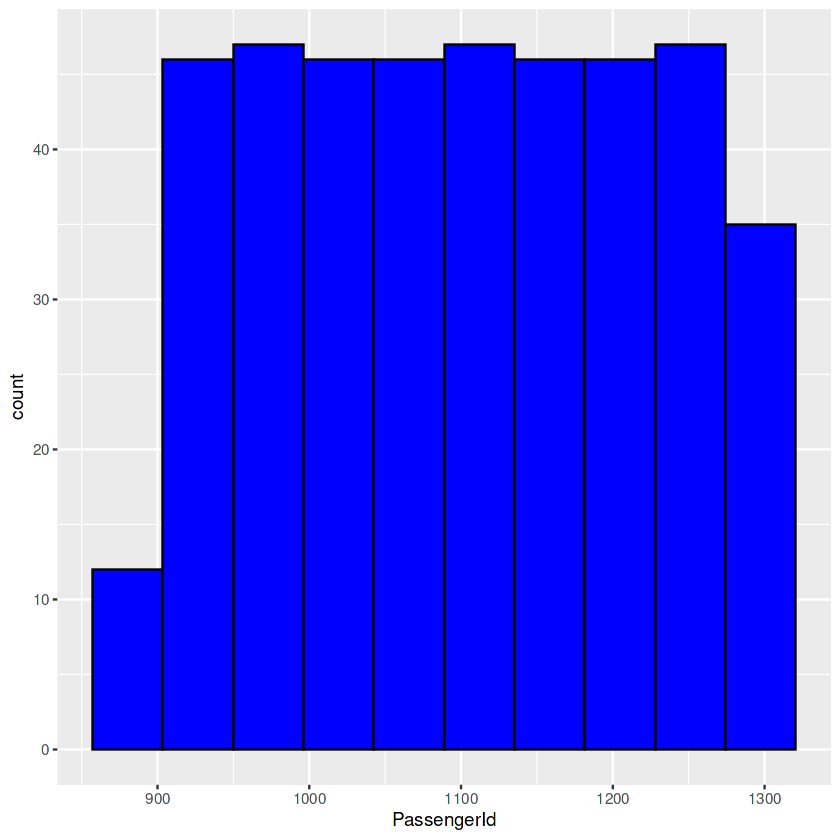

,PassengerId,Survived
,<dbl>,<fct>
1,892,0
2,893,0
3,894,0
4,895,0
5,896,0
6,897,0
7,898,1
8,899,0
9,900,1


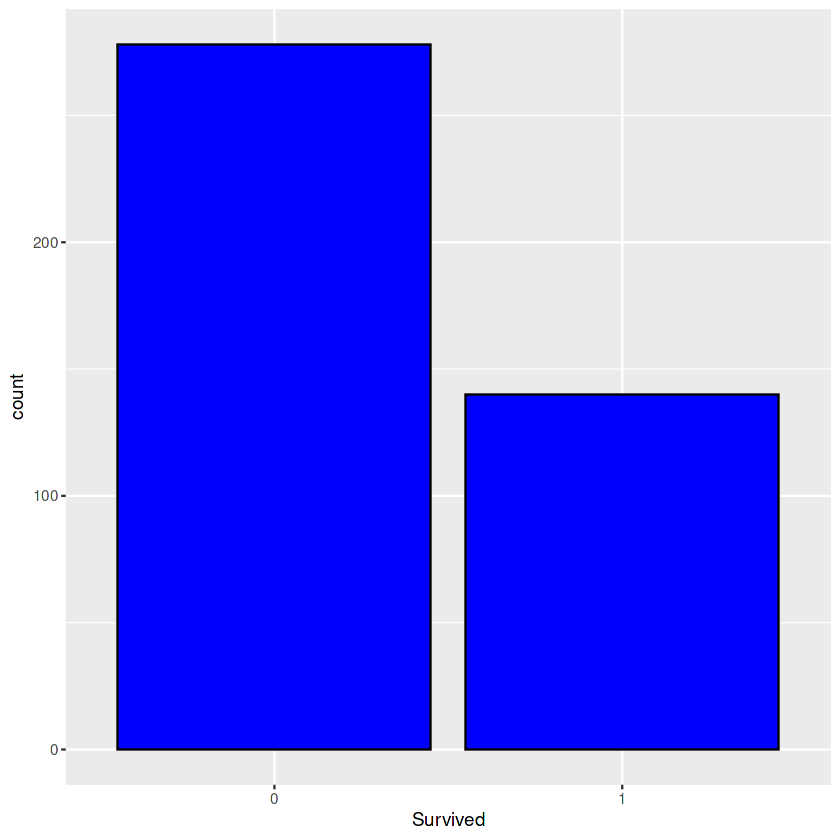

In [6]:
#make my prediction dataset into a dataframe
prediction_df <- as.data.frame(prediction)

#combine my survival predictions with the test dataset
final_prediction_df <- cbind(test_selected, prediction_df)

#Convert the prediction variable from a factor to numeric
final_prediction_df <- final_prediction_df %>%
    rename(Survived = prediction) %>%
    mutate(Survived = as.numeric(Survived)) %>%
    mutate(Survived = if_else(Survived == 1, 0, 1))


#Select just the passsengerId and Survived, converting Survived back to a factor in order to graph easier later
#save in a different dataframe called final_prediction_selected
final_prediction_selected <- final_prediction_df %>%
    select(PassengerId, Survived) %>%
    mutate(Survived = factor(Survived)) 

#Find the total amount that survived and did not survive from my prediction of the test dataset 
#278 people did not survive and 140 people did survive
final_prediction_df %>%
    group_by(Survived) %>%
    summarize(survival_outcome_num = length(Survived))

#Visualize the passsengerIds as shown in the example submission file
ggplot(final_prediction_selected, aes(PassengerId)) +
    geom_histogram(bins = 10, color = "black", fill = "blue") +
    scale_x_continuous()

#Visualize the final prediction as shown in the example submission file
ggplot(final_prediction_selected, aes(Survived)) +
    geom_bar(color = "black", fill = "blue")

final_prediction_selected

write.csv(final_prediction_selected, "submission.csv")